<b><font size=6>Machine Learning for Networking - Project 9<b>

##Introduction:
This project is about applying machine learning techniques to analyze **encrypted traffic** sent using the **https protocol**. Despite https protocol aims to protect user privacy, domain names in a packet flow are still transmitted in plain text, potentially exposing sensitive information to interceptors.


The provided dataset was collected in July 2019 using **Tstat**, a passive traffic monitoring tool that **aggregates TCP/UDP flows**. The tool basically capture packets that are transmitted on the monitored link. TStat group packets according to the following charateristics: \\
*Flow = (Protocol, IP Source Address, Source Port, IP Destination Address, Destination Port).*

The final dataset is composed of **125 features**, 122 numerical described with an initial “_” in the featurename, plus the client IP address, the time when this flow was generated and the label.

##Goals:
The project is about appling machine learning techniques in order to solve the following tasks:

1. **Supervised learning**: for each TCP connection, **identify and classify** the service that generated the traffic;
2. **Unsupervised learning**: **cluster** the domain name of the service giving the traffic they all produces;
3. **Regression**: **predict** the number of bytes transmitted by a service and the average round trip time of each flow;

# Section 1 – Data exploration and pre-processing

Before even starting preprocessing data, we need to understand more about the dataset we're analyzing.

> **Each row** of the dataset represent a **the packet flow exchanged during a TCP connection between an host and a server**

> **Each feature** of the dataset is **a statistic about the exchanged packets, the TCP connection and both the client and the server**



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.naive_bayes import GaussianNB
#from sklearn.linear_model import LinearRegression
from sklearn.metrics import balanced_accuracy_score, f1_score
#from sklearn.tree import DecisionTreeRegressor
#from scipy import stats
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv('/content/drive/MyDrive/ML4N_project/https_training.csv')
df

,_c_ack_cnt,_c_ack_cnt_p,_c_appdataB,_c_appdataT,_c_bytes_all,_c_bytes_retx,_c_bytes_uniq,_c_cwin_ini,_c_cwin_max,_c_cwin_min,...,_s_ttl_max,_s_ttl_min,_s_win_0,_s_win_max,_s_win_min,_s_win_scl,_tls_session_stat,c_ip,time,label
0,8.0,4.0,569.0,522.003,1672.0,0.0,1672.0,517.0,590.0,51.0,...,59.0,59.0,0.0,31232.0,27680.0,9.0,1.0,67.32.225.92,1.561932e+09,krxd.net
1,10.0,7.0,275.0,39.504,636.0,0.0,636.0,181.0,362.0,1.0,...,59.0,59.0,0.0,29480.0,27680.0,0.0,0.0,67.32.181.213,1.561932e+09,_other
2,7.0,3.0,569.0,110.003,3325.0,0.0,3325.0,517.0,1435.0,51.0,...,59.0,59.0,0.0,34304.0,27680.0,9.0,1.0,67.32.225.92,1.561932e+09,contextweb.com
3,8.0,3.0,453.0,8.813,958.0,0.0,958.0,401.0,557.0,1.0,...,59.0,59.0,0.0,30208.0,27920.0,9.0,0.0,67.32.124.163,1.561932e+09,twitchcdn.net
4,6.0,2.0,0.0,0.000,452.0,0.0,452.0,401.0,401.0,1.0,...,59.0,59.0,0.0,29184.0,27920.0,9.0,0.0,67.32.124.163,1.561932e+09,twitchcdn.net
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147858,8.0,3.0,453.0,10.011,907.0,0.0,907.0,401.0,506.0,51.0,...,59.0,59.0,0.0,30208.0,27920.0,9.0,0.0,67.32.124.163,1.562018e+09,twitchcdn.net
147859,12.0,4.0,446.0,16.000,2068.0,0.0,2068.0,394.0,838.0,51.0,...,59.0,59.0,0.0,33792.0,27920.0,9.0,0.0,67.32.124.163,1.562018e+09,twitch.tv
147860,12.0,6.0,306.0,53.987,430.0,0.0,430.0,212.0,212.0,38.0,...,59.0,59.0,0.0,29184.0,27920.0,9.0,0.0,67.32.230.26,1.562019e+09,everesttech.net
147861,13.0,6.0,306.0,54.000,886.0,0.0,886.0,212.0,543.0,38.0,...,59.0,59.0,0.0,30208.0,27920.0,9.0,0.0,67.32.230.26,1.562019e+09,everesttech.net


In [3]:
print("Dataset shape: ", df.shape)
df.info()
print('-'*100)
print("Number of duplicated lines: ", df.duplicated().sum())
print('-'*100)
print("Number of missing values:", df.isna().sum().sum())

Dataset shape:  (147863, 123)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147863 entries, 0 to 147862
Columns: 123 entries, _c_ack_cnt to label
dtypes: float64(121), object(2)
memory usage: 138.8+ MB
----------------------------------------------------------------------------------------------------
Number of duplicated lines:  0
----------------------------------------------------------------------------------------------------
Number of missing values: 0


In [4]:
def drop_zeros_features(df):
  zero_columns = [col for col in df.columns if (df[col] == 0).all()]
  return df.drop(columns=zero_columns)

print("Dataset shape BEFORE noise reduction: ", df.shape)
remaining_zero_columns = [col for col in df.columns if (df[col] == 0).all()]
print(remaining_zero_columns)
print("Number of zero columns", len(remaining_zero_columns))
print("-"*100)

df_no_zeros = drop_zeros_features(df.copy())
print("Dataset shape AFTER noise reduction: ", df_no_zeros.shape)
df = df_no_zeros
remaining_zero_columns = [col for col in df.columns if (df[col] == 0).all()]
print("Number of zero columns", len(remaining_zero_columns))
print("-"*100)

Dataset shape BEFORE noise reduction:  (147863, 123)
['_c_pkts_fc', '_c_pkts_unfs', '_c_syn_retx', '_s_pkts_unfs', '_s_syn_retx', '_s_win_0']
Number of zero columns 6
----------------------------------------------------------------------------------------------------
Dataset shape AFTER noise reduction:  (147863, 117)
Number of zero columns 0
----------------------------------------------------------------------------------------------------


The first thing to do is to **explore the dataset and learn about feature behavior**.
This task must be performed at **different levels**: flow level (rows of the dataset), at the IP level (clients) and domain name level (labels).

In [5]:
df_flow_level = df.copy()
df_ip_level_gb = df.copy().drop(columns=['label','_s_port', '_c_port']).groupby('c_ip')
df_domain_level_gb = df.copy().drop(columns=['c_ip', '_s_port', '_c_port']).groupby('label')

In [6]:
def features_categorization(all_features):

  special_features={
      "count" : ['_c_bytes_uniq', '_c_pkts_ooo', '_c_pkts_push', '_c_pkts_reor', '_c_pkts_unrto',
                 '_c_pkts_rto', '_c_pkts_unk', '_c_win_0', '_s_bytes_uniq', '_s_bytes_uniq',
                 '_s_pkts_fc', '_s_pkts_fs', '_s_pkts_ooo', '_s_pkts_push', '_s_pkts_reor', '_s_pkts_rto',
                 '_s_pkts_unk', '_s_pkts_unrto', '_c_pkts_fc', '_c_pkts_unfs', '_s_pkts_unfs',
                 '_c_syn_retx', '_s_syn_retx', '_s_win_0'],
      "maximum" : ['_c_mss', '_s_mss']
  }

  categorization = {
    "average": [],
    "maximum": [],
    "minimum": [],
    "count": [],
    "temporal": [],
    "boolean": [],
    "default": []
  }

  for feature in all_features:
    if 'avg' in feature:
      categorization['average'].append(feature)
    elif 'max' in feature or feature in special_features['maximum']:
      categorization['maximum'].append(feature)
    elif 'min' in feature or feature == 'time':
      categorization['minimum'].append(feature)
    elif 'cnt' in feature or\
           'all' in feature or\
            'data' in feature or\
             'dup' in feature  or\
              'retx' in feature or\
               'count' in feature or\
                  feature in special_features['count']:
      categorization['count'].append(feature)
    elif 'first' in feature or 'last' in feature:
      categorization['temporal'].append(feature)
    else:
      if (feature != 'c_ip' and feature != 'label') and ('opt' in feature or feature == '_s_win_scl'):
          categorization['boolean'].append(feature)
      elif feature != 'c_ip' and feature != 'label' and feature != '_c_port' and feature != '_s_port':
         categorization['default'].append(feature)
  return categorization

aggregation_functions = {
    "average": 'mean',
    "maximum": 'max',
    "minimum": 'min',
    "count": 'sum',
    "temporal": 'max',
    "boolean": lambda x: round(np.mean(x)),
    "default": 'mean'
}

all_features = df.columns.tolist()
categorization = features_categorization(all_features)

aggregation_map = {}
for category, features in categorization.items():
    for feature in features:
        aggregation_map[feature] = aggregation_functions[category]

df_ip_level = df_ip_level_gb.agg(aggregation_map).reset_index()
df_domain_level = df_domain_level_gb.agg(aggregation_map).reset_index()

print(df_flow_level.shape)
print(df_ip_level.shape)
print(df_domain_level.shape)

(147863, 117)
(738, 114)
(26, 114)


#### **EPDF and ECDF of features distributions**

Working at flow level means working with the original dataset, the one imported at the beginning of the python notebook. This dataset has a shape of (147863, 123), meaning we are dealing with **123 features**.
We can use data visualization techniques to plot feature distribution. This helps us to better understand the information carried by the features.


The time period is from  2019-06-30 21:55:48.407464960  to  2019-07-01 22:03:05.570235136 



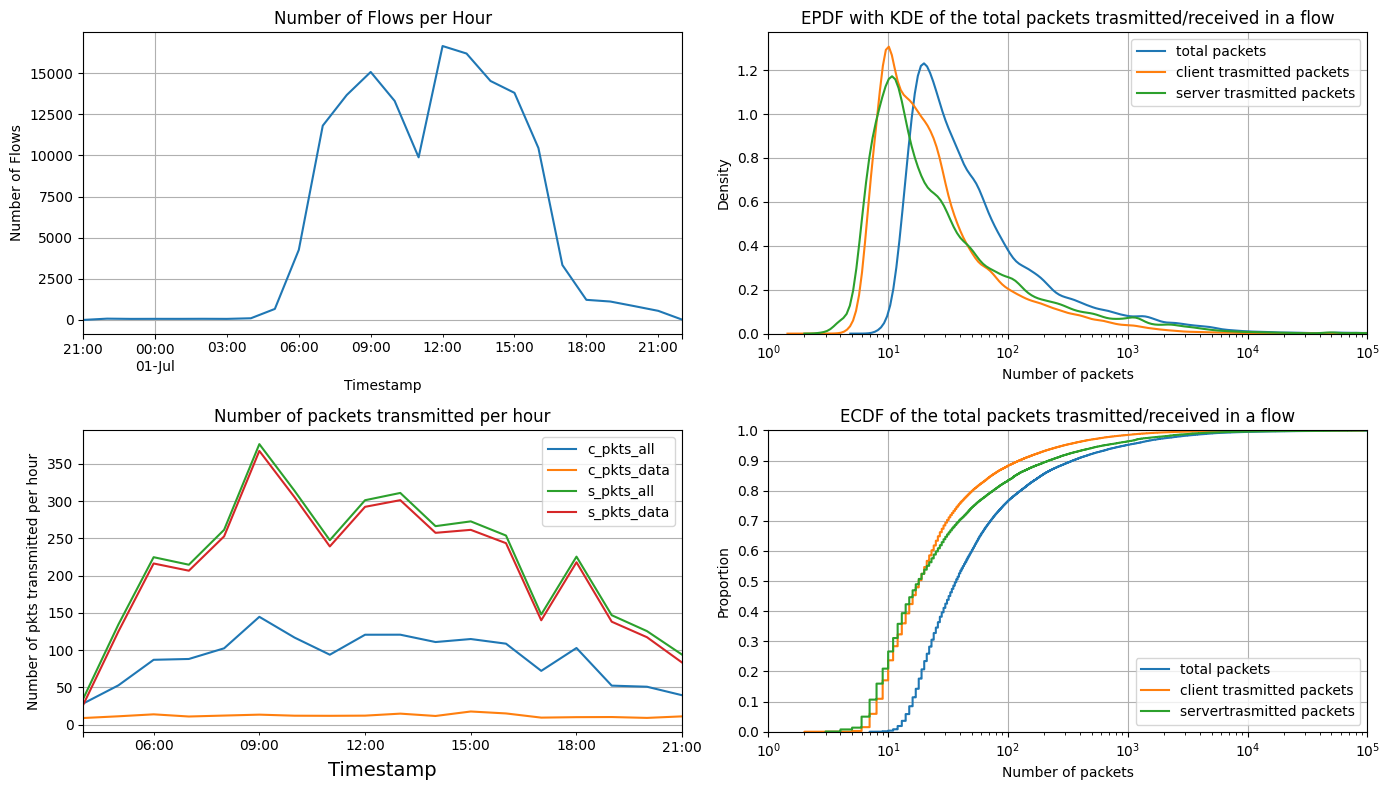

In [7]:
def timestamp_conversion(df, unit_of_time):
    df_copy = df.copy()
    df_copy['time'] = df_copy['time'] * 1e9 # convert second to millisecond
    df_copy['time'] = pd.to_datetime(df_copy['time']) # change to datetime
    df_copy.set_index('time', inplace=True) # set the timestamp as index
    df_result = df_copy.resample(f'{unit_of_time}s')
    return df_result

df_timestamp = timestamp_conversion(df_flow_level, 3600)
time_range={'minimum' : pd.to_datetime(df_flow_level['time']* 1e9).min(), 'maximum' : pd.to_datetime(df_flow_level['time']* 1e9).max()}
print ('The time period is from ',time_range['minimum'], ' to ', time_range['maximum'],'\n')

fig, ax = plt.subplots(2,2,figsize=(14, 8))

# Number of flows per hour
df_timestamp.count()['c_ip'].plot(ax=ax[0,0])
ax[0,0].set_xlabel('Timestamp')
ax[0,0].set_ylabel('Number of Flows')
ax[0,0].set_title('Number of Flows per Hour')
ax[0,0].grid()

#Number of packets per hour
df_timestamp.mean(numeric_only=True)['2019-07-01 04:00:00':'2019-07-01 21:00:00']['_c_pkts_all'].plot(ax=ax[1, 0], label='c_pkts_all')
df_timestamp.mean(numeric_only=True)['2019-07-01 04:00:00':'2019-07-01 21:00:00']['_c_pkts_data'].plot(ax=ax[1, 0], label='c_pkts_data')
df_timestamp.mean(numeric_only=True)['2019-07-01 04:00:00':'2019-07-01 21:00:00']['_s_pkts_all'].plot(ax=ax[1, 0], label='s_pkts_all')
df_timestamp.mean(numeric_only=True)['2019-07-01 04:00:00':'2019-07-01 21:00:00']['_s_pkts_data'].plot(ax=ax[1, 0], label='s_pkts_data')

ax[1, 0].set_xlabel('Timestamp',fontsize=14)
ax[1, 0].set_ylabel('Number of pkts transmitted per hour')
ax[1, 0].set_title('Number of packets transmitted per hour')
ax[1, 0].legend()
ax[1, 0].grid()


sns.kdeplot(df_flow_level['_c_pkts_all'] + df_flow_level['_s_pkts_all'], log_scale=True, ax=ax[0,1], label= 'total packets')
sns.kdeplot(df_flow_level['_c_pkts_all'], log_scale=True, ax=ax[0,1], label = 'client trasmitted packets')
sns.kdeplot(df_flow_level['_s_pkts_all'], log_scale=True, ax=ax[0,1], label = 'server trasmitted packets')
ax[0,1].set_title('EPDF with KDE of the total packets trasmitted/received in a flow')
ax[0,1].set_xlabel('Number of packets')
ax[0,1].set_xlim(1,10**5)
ax[0,1].grid()
ax[0,1].legend()

sns.ecdfplot(df_flow_level['_c_pkts_all'] + df_flow_level['_s_pkts_all'], log_scale=True, ax=ax[1,1], label = 'total packets')
sns.ecdfplot(df_flow_level['_c_pkts_all'], log_scale=True, ax=ax[1,1], label = 'client trasmitted packets')
sns.ecdfplot(df_flow_level['_s_pkts_all'], log_scale=True, ax=ax[1,1], label = 'servertrasmitted packets')
ax[1,1].set_yticks(np.arange(0,1.1, 0.1))
ax[1,1].set_xlim(1,10**5)
ax[1,1].set_title('ECDF of the total packets trasmitted/received in a flow')
ax[1,1].set_xlabel('Number of packets')
ax[1,1].grid()
ax[1,1].legend()


plt.tight_layout()  # Adjust spacing between subplots
plt.show()


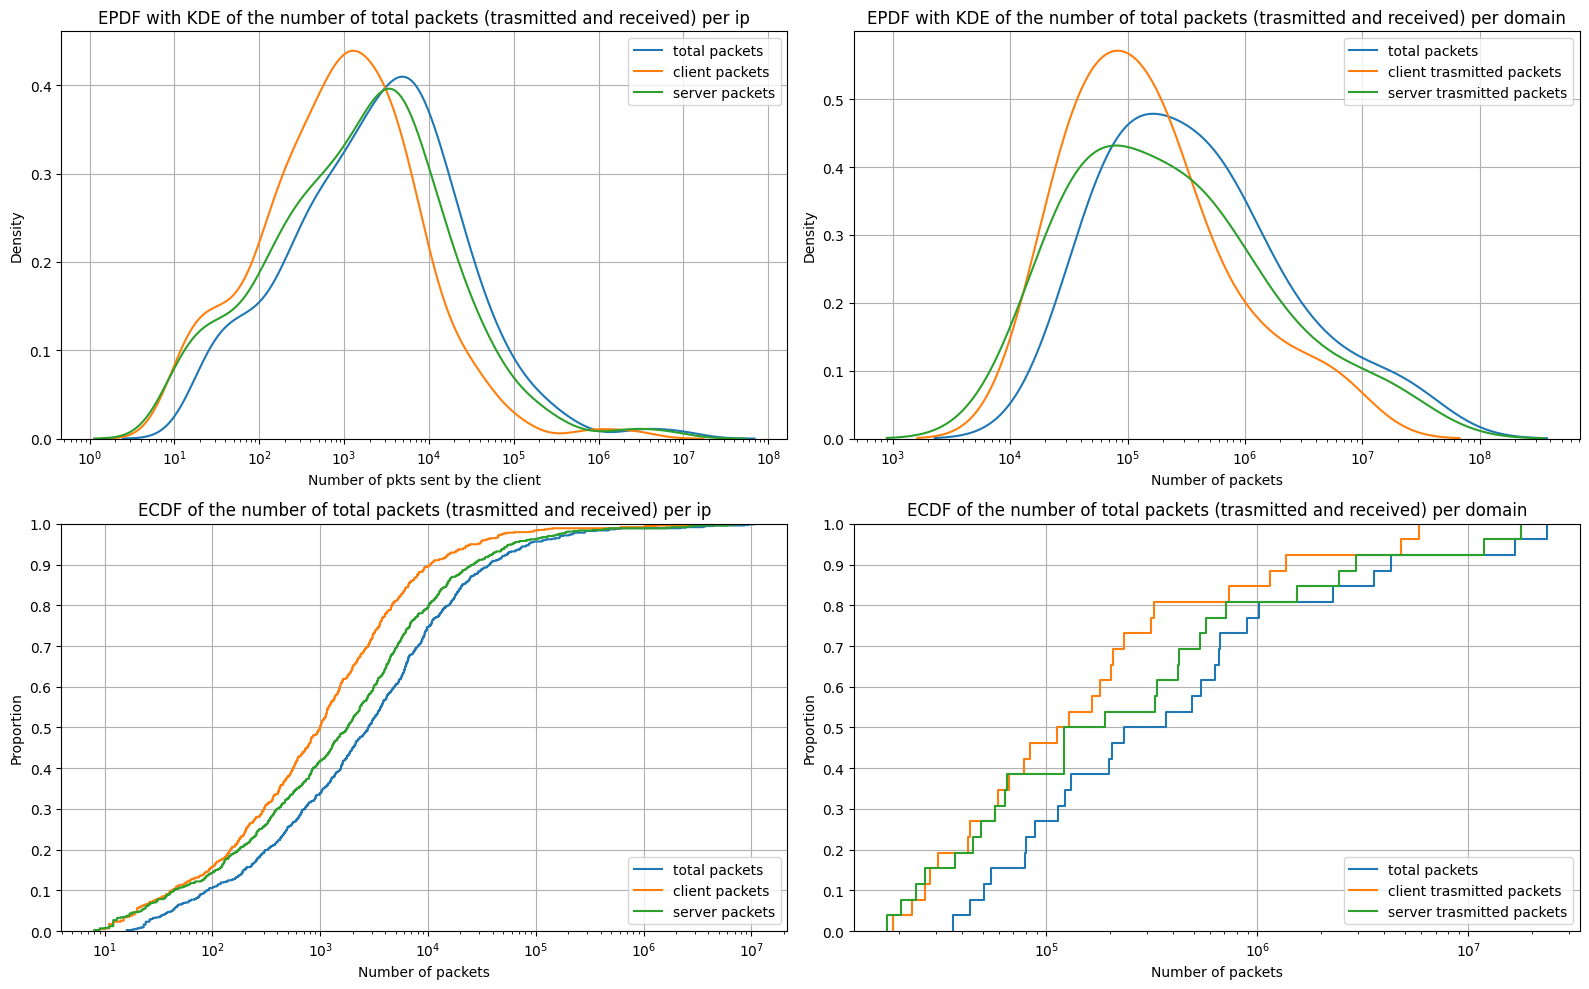

In [8]:
fig, ax = plt.subplots(2,2,figsize=(16, 10))

sns.kdeplot(df_ip_level['_c_pkts_all']+df_ip_level['_s_pkts_all'], ax=ax[0,0], log_scale=True, label='total packets')
sns.kdeplot(data=df_ip_level, x="_c_pkts_all", ax=ax[0,0], log_scale=True, label='client packets')
sns.kdeplot(data=df_ip_level, x="_s_pkts_all", ax=ax[0,0], log_scale=True, label='server packets')
ax[0,0].set_title('EPDF with KDE of the number of total packets (trasmitted and received) per ip')
ax[0,0].set_xlabel("Number of pkts sent by the client")
ax[0,0].legend()
ax[0,0].grid()

sns.ecdfplot(df_ip_level['_c_pkts_all']+df_ip_level['_s_pkts_all'], label='total packets', log_scale=True, ax=ax[1,0])
sns.ecdfplot(df_ip_level['_c_pkts_all'], label='client packets', log_scale=True, ax=ax[1,0])
sns.ecdfplot(df_ip_level['_s_pkts_all'], label='server packets', log_scale=True, ax=ax[1,0])
ax[1,0].set_yticks(np.arange(0,1.1, 0.1))
ax[1,0].set_title('ECDF of the number of total packets (trasmitted and received) per ip')
ax[1,0].set_xlabel('Number of packets')
ax[1,0].legend(loc=4)
ax[1,0].grid()
plt.tight_layout()


sns.kdeplot(df_domain_level['_c_pkts_all'] + df_domain_level['_s_pkts_all'], ax=ax[0,1], log_scale=True, label='total packets')
sns.kdeplot(data=df_domain_level, x="_c_pkts_all", ax=ax[0,1], log_scale=True, label='client trasmitted packets')
sns.kdeplot(data=df_domain_level, x="_s_pkts_all", ax=ax[0,1], log_scale=True, label='server trasmitted packets')
ax[0,1].set_title('EPDF with KDE of the number of total packets (trasmitted and received) per domain')
ax[0,1].set_xlabel("Number of packets")
ax[0,1].grid()
ax[0,1].legend()

sns.ecdfplot(df_domain_level['_c_pkts_all'] + df_domain_level['_s_pkts_all'], label='total packets', log_scale=True, ax=ax[1,1])
sns.ecdfplot(df_domain_level['_c_pkts_all'], label='client trasmitted packets', log_scale=True, ax=ax[1,1])
sns.ecdfplot(df_domain_level['_s_pkts_all'], label='server trasmitted packets', log_scale=True, ax=ax[1,1])
ax[1,1].set_yticks(np.arange(0,1.1, 0.1))
ax[1,1].set_title('ECDF of the number of total packets (trasmitted and received) per domain')
ax[1,1].set_xlabel('Number of packets')
ax[1,1].grid()
ax[1,1].legend(loc=4)

plt.tight_layout()
plt.show()



---



###**Correlation analysis**

After exploring the dataset features distribution by plotting ECDF and EPDF, we can do a **correlation analysis** in order to better understand feature behaviour. The idea is to compute the correlation matrix at each level, plot it using an heatmap and then find the 3 most correlated pairs of features.

In [9]:
def make_heatmap(correlation_matrix, ax):
  # display the heatmap
  sns.heatmap(correlation_matrix, cmap='Blues', vmin=0, vmax=1, cbar_kws={'label':'Correlation'}, xticklabels=False, yticklabels=False, ax=ax)
  ax.set_xlabel('Feature')
  ax.set_ylabel('Feature')

def find_most_correlated_features(correlation_matrix, n):
  highly_correlated_features = dict()
  to_del = set()
  for f1 in correlation_matrix.columns:
    for f2 in correlation_matrix.index:
      if f1 != f2 and (f2,f1) not in highly_correlated_features and correlation_matrix[f1][f2] >= 0.8:
        highly_correlated_features[(f1, f2)] = correlation_matrix[f1][f2]

  #Loop to get the features to delete
  for (x,y) in highly_correlated_features.keys():
      to_del.add(y)

  print('The highly correlated couples are:', len(highly_correlated_features.keys()),',',len(to_del),' features can be deleted\n')

  return dict(sorted(highly_correlated_features.items(), key=lambda item: item[1], reverse=True)[:n])

def print_correlated (cor_feat, level):
    print('The ', len(cor_feat), 'most correlated features at', level, 'level are:')
    for (f1, f2), value in cor_feat.items():
        print(f1, '\t', f2, ':', f"{value:.1f}" )


 ----------------------------------------------------------------------------------------------------
The highly correlated couples are: 135 , 47  features can be deleted

The  3 most correlated features at flow level are:
_s_f1323_opt 	 _s_win_scl : 1.0
_c_pkts_data 	 _c_pktsize_count : 1.0
_c_tm_opt 	 _s_tm_opt : 1.0

 ----------------------------------------------------------------------------------------------------
The highly correlated couples are: 1365 , 68  features can be deleted

The  3 most correlated features at ip level are:
_c_pkts_data 	 _c_pktsize_count : 1.0
_s_pkts_data 	 _s_pktsize_count : 1.0
_c_tm_opt 	 _s_tm_opt : 1.0

 ----------------------------------------------------------------------------------------------------
The highly correlated couples are: 1009 , 68  features can be deleted

The  3 most correlated features at domain level are:
_c_mss 	 _s_win_min : 1.0
_c_pkts_data 	 _c_pktsize_count : 1.0
_s_pkts_data 	 _s_pktsize_count : 1.0


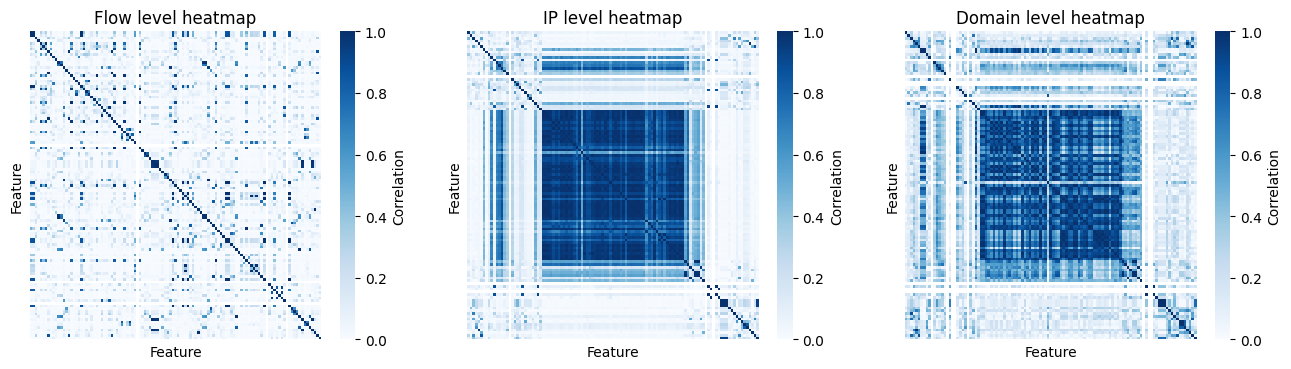

In [10]:
correlation_matrix_fl = df_flow_level.select_dtypes(include=np.number).corr().abs()
correlation_matrix_ipl = df_ip_level.select_dtypes(include=np.number).corr().abs()
correlation_matrix_dnl = df_domain_level.select_dtypes(include=np.number).corr().abs()


fig, ax = plt.subplots(1,3, figsize=(16,4))
make_heatmap(correlation_matrix_fl, ax[0])
make_heatmap(correlation_matrix_ipl, ax[1])
make_heatmap(correlation_matrix_dnl, ax[2])
ax[0].set_title('Flow level heatmap')
ax[1].set_title('IP level heatmap')
ax[2].set_title('Domain level heatmap')

print('\n','-'*100)
mcf_fl = find_most_correlated_features(correlation_matrix_fl, 3)
print_correlated(mcf_fl, 'flow')

print('\n','-'*100)
mcf_ipl = find_most_correlated_features(correlation_matrix_ipl, 3)
print_correlated(mcf_ipl, 'ip')

print('\n','-'*100)
mcf_dnl = find_most_correlated_features(correlation_matrix_dnl, 3)
print_correlated(mcf_dnl, 'domain')



---



###**Statistics about the number of bytes and rtt**





After correlation analysis, we want to understand how features about **round trip time** and **number of bytes** transmitted are behaving. To do so, we want to plot statistics about the related features. \\
According to dataset documentation, these are the features about transmitted bytes:

* **\_c_bytes_all**: The total number of bytes sent by the client.
* **\_c_bytes_retx**: The number of bytes of retransmitted data sent by the client.
* **\_c_bytes_uniq**: The number of unique bytes sent by the client.
* **\_s_bytes_all**: Total number of bytes sent by the server.
* **\_s_bytes_retx**: Number of bytes retransmitted by the server.
* **\_s_bytes_uniq**: Number of unique bytes sent by the server.

count    147863.000000
mean         43.537518
std         817.038489
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      197307.000000
Name: _c_bytes_retx, dtype: float64 

count    1.478630e+05
mean     2.697272e+03
std      8.011790e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.065578e+07
Name: _s_bytes_retx, dtype: float64 



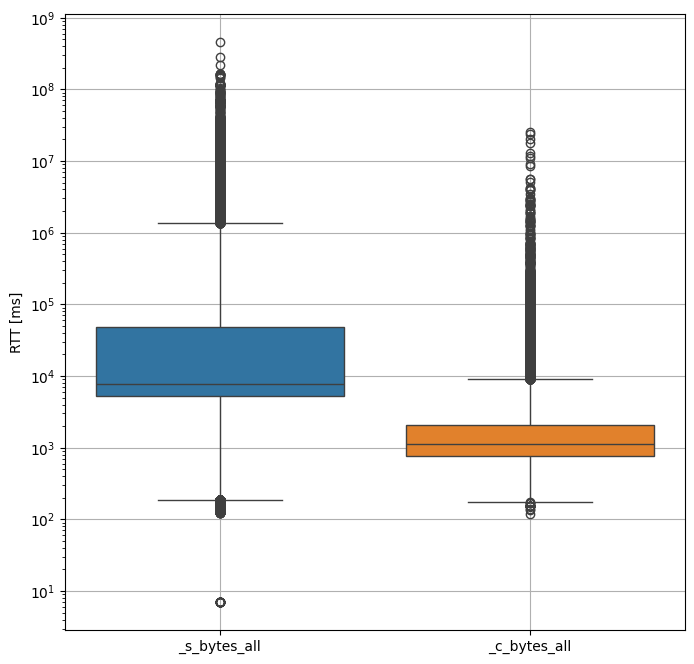

In [11]:
fig,ax = plt.subplots(1,1,figsize=(8,8))

sns.boxplot(data=[df_flow_level['_s_bytes_all'],df_flow_level['_c_bytes_all']],log_scale=True, ax = ax )
#sns.boxplot(data=[df_flow_level['_s_bytes_uniq'],df_flow_level['_c_bytes_uniq']],log_scale=True, ax = ax )

print(df_flow_level['_c_bytes_retx'].describe(),'\n')
print(df_flow_level['_s_bytes_retx'].describe(),'\n')
ax.set_ylabel('RTT [ms]')

ax.grid()
plt.show()

According to dataset documentation, these are the features about round trip time:

* **\_c_rtt_avg**: Average round-trip time (RTT) for packets sent by the client.
* **\_c_rtt_cnt**: Number of RTT measurements for packets sent by the client.
* **\_c_rtt_max**: Maximum RTT for packets sent by the client.
* **\_c_rtt_min**: Minimum RTT for packets sent by the client.
* **\_c_rtt_std**: Standard deviation of the RTT for packets sent by the client.
* **\_s_rtt_avg**: Average round-trip time (RTT) for packets sent by the server.
* **\_s_rtt_cnt**: Number of RTT measurements for packets sent by the server.
* **\_s_rtt_max**: Maximum RTT for packets sent by the server.
* **\_s_rtt_min**: Minimum RTT for packets sent by the server.
* **\_s_rtt_std**: Standard deviation of the RTT for packets sent by the server.

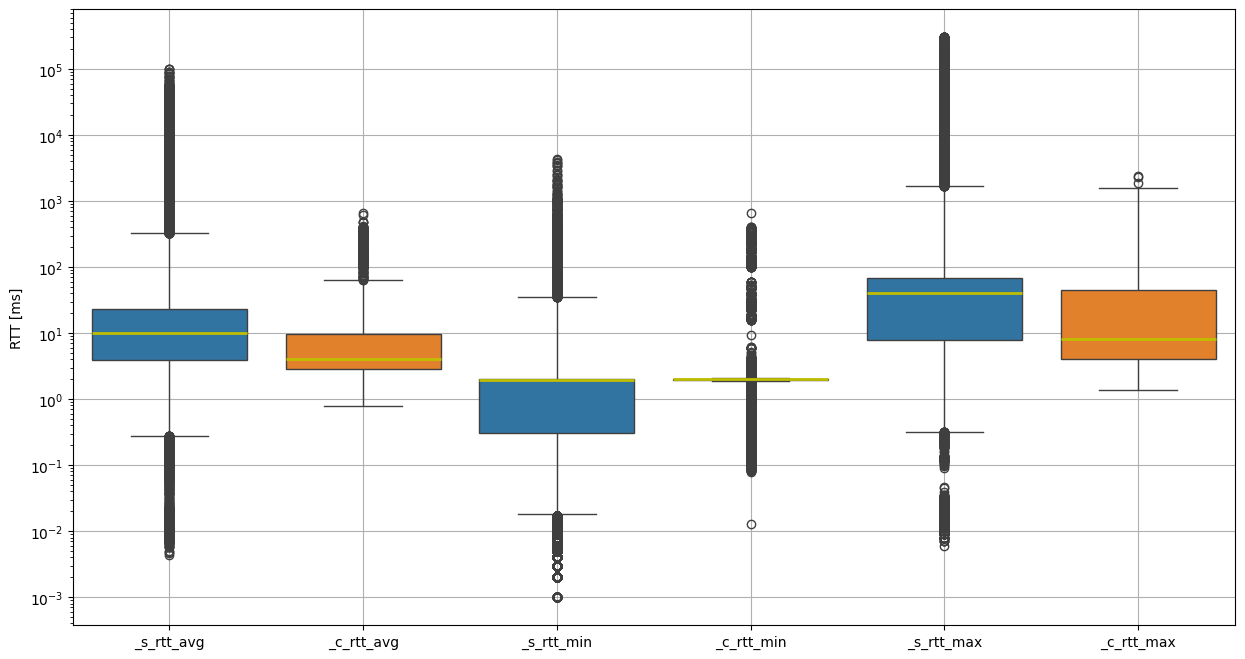

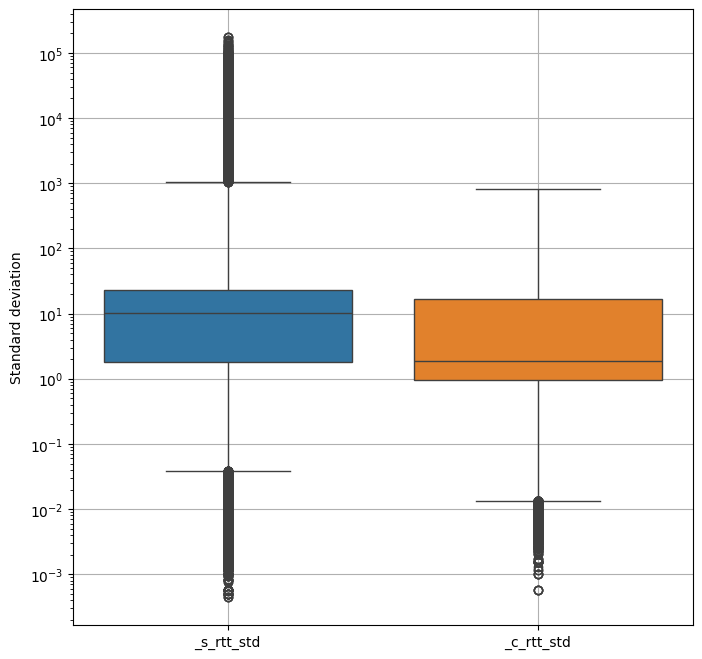

In [12]:
fig,ax = plt.subplots(1,1,figsize=(15,8))

sns.boxplot(data=[df_flow_level['_s_rtt_avg'],df_flow_level['_c_rtt_avg']],log_scale=True, ax = ax ,medianprops={"color": "y", "linewidth": 2})
sns.boxplot(data=[df_flow_level['_s_rtt_min'],df_flow_level['_c_rtt_min']],log_scale=True, ax = ax ,medianprops={"color": "y", "linewidth": 2})
sns.boxplot(data=[df_flow_level['_s_rtt_max'],df_flow_level['_c_rtt_max']],log_scale=True, ax = ax ,medianprops={"color": "y", "linewidth": 2})
#sns.boxplot(data=[df_flow_level['_s_rtt_cnt'],df_flow_level['_c_rtt_cnt']],log_scale=True, ax = ax[0] )
ax.set_ylabel('RTT [ms]')
ax.grid()
plt.show()

fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.boxplot(data=[df_flow_level['_s_rtt_std'],df_flow_level['_c_rtt_std']],log_scale=True, ax = ax)
ax.set_ylabel('Standard deviation')
ax.grid()
plt.show()



### **Dimensionality reduction: PCA and t-SNE**

To conclude the data preprocessing part, we can apply two techniques for **dimensionality reduction**: the PCA and the t-SNE. \\
They both aim at reducing the dimentionality of data, in terms of features, by changing the space of data from an high-dimentional one to one with few dimentions.

In [13]:

def standardize_data(df_copy):

  numerical_features = df_copy.select_dtypes(include=np.number)

  scaler = StandardScaler()
  standardized_data = scaler.fit_transform(numerical_features)
  standardized_df = pd.DataFrame(standardized_data,
                                  columns=numerical_features.columns,
                                  index=df_copy.index)  # Preserve original index
  final_df = pd.concat([standardized_df, df_copy.select_dtypes(exclude=np.number)], axis=1) #ottenere iol dataframe finale rimettendo le features non numeriche

  return final_df


# function to plot standardization results
def standardization_results(df_standardized):

  numerical_df = df_standardized.select_dtypes(include=np.number)
  # ndimensional array of standard deviations among each feature (after standardization)
  std_ndarray = np.array([numerical_df[feature].std() for feature in numerical_df.columns])
  # ndimensional array of means among each feature (after standardization)
  mean_ndarray = np.array([numerical_df[feature].mean() for feature in numerical_df.columns])

  mean_of_means = abs(np.mean(mean_ndarray))
  mean_of_stds = np.mean(std_ndarray)

  print("Standardization results: ")
  print("Means of feature means: ", mean_of_means)
  print("Means of feature standard deviations: ", mean_of_stds)


# data standardization
df_copy = df.copy()
df_standardized = standardize_data(df_copy)
df_standardized = drop_zeros_features(df_standardized)
standardization_results(df_standardized)

Standardization results: 
Means of feature means:  2.156093574216957e-14
Means of feature standard deviations:  1.00000338152569


##### **PCA implementation**

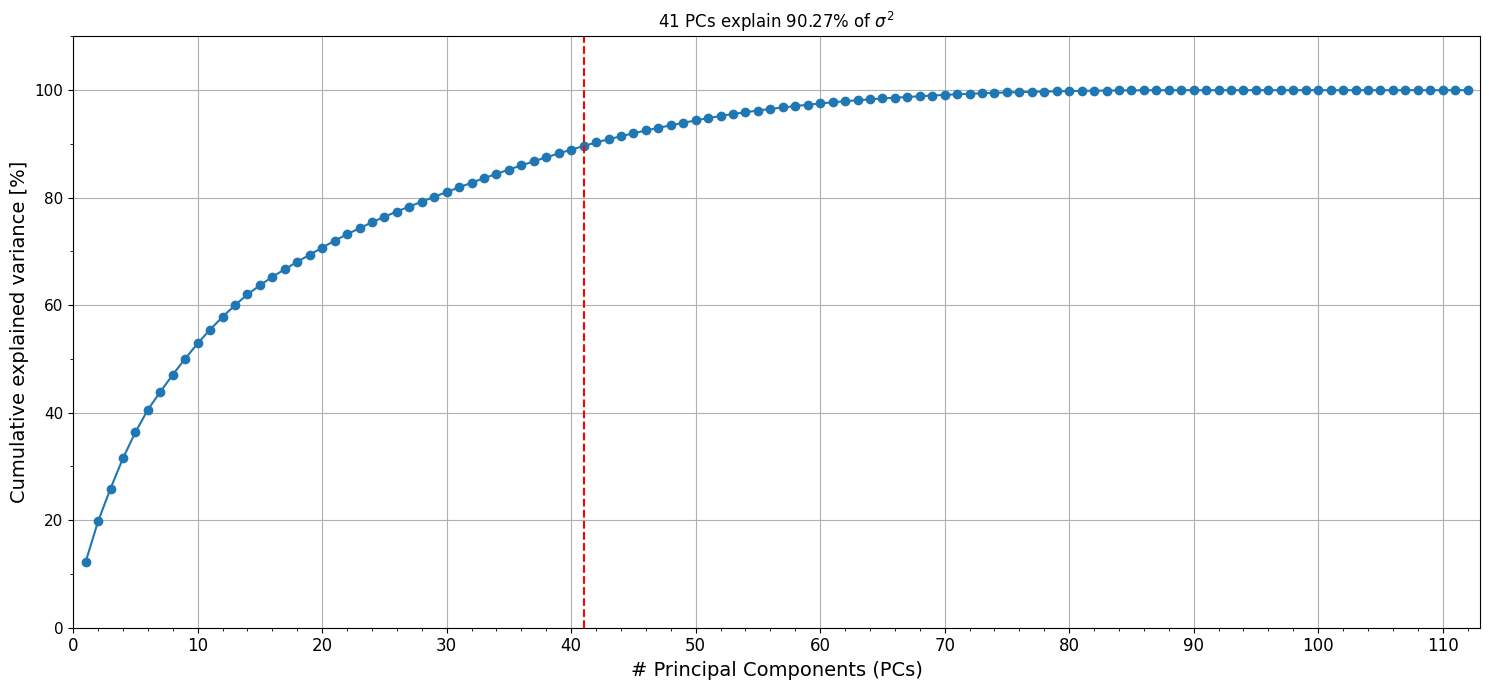

In [14]:
# PCA visualization
pca = PCA(random_state=15)
# .fit() is used to compute the new dimensions with number of features from 1 to the number of original features
pca.fit(df_standardized.copy().drop(columns=['c_ip', 'label']))

# describe how much of the dataset variability is indicated by a given amount of features
explained_variance = pca.explained_variance_ratio_
cumul_exp_var = np.cumsum(explained_variance)
perc_cumul_exp_var = cumul_exp_var*100
n_pcs = [index for index in range(len(cumul_exp_var)) if cumul_exp_var[index] >= 0.90][0]

# make the plot of cumulative explained variance wrt number of components
plt.figure(figsize=(15, 7))
x_values = np.arange(1,len(perc_cumul_exp_var)+1, 1)
plt.plot(x_values,perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)', fontsize=14)
plt.ylabel('Cumulative explained variance [%]', fontsize=14)
plt.xticks(np.arange(0, len(perc_cumul_exp_var)+1, 10), fontsize=12)
plt.xticks(np.arange(0, len(perc_cumul_exp_var)+1, 2), fontsize=12, minor=True)
plt.xlim(0,x_values[-1]+1)

plt.yticks(np.arange(0, 120, 20), fontsize=11)
plt.yticks(np.arange(0, 120, 10), fontsize=11, minor= True)
plt.title(f'{n_pcs} PCs explain {round(perc_cumul_exp_var[n_pcs], 2)}% of $\sigma^2$')
plt.grid()
plt.tight_layout()

plt.axvline(x=n_pcs, color='red', linestyle='--')

plt.show()

Due to large dimentionality of datas (number of features), **there is no clear elbow**. However, since we're going to use this "reduced" dataset in the supervised learning task, we need it to be rapresentative with the respect of the original one. \\
So we seat a threshold for explained variance: we want it to be higher than 90%

In [15]:
# PCA transformation

# initialize the PCA with the best number of components, in this case, it's 41
pca = PCA(n_components=n_pcs, random_state=15)
# fit the data to new space
pca.fit(df_standardized.copy().drop(columns=['c_ip', 'label']))
# transform the original data into PCA components
pca_result = pca.transform(df_standardized.copy().drop(columns=['c_ip', 'label']))
# create the new dataset
df_pca = pd.DataFrame(pca_result,  columns=[f'pc{i}' for i in range(1, n_pcs+1)])
df_pca['c_ip'] = df['c_ip']
df_pca['label'] = df['label']
df_pca

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,c_ip,label
0,-0.541305,-0.155528,-1.179376,0.370705,-3.580162,-1.107504,0.643555,-0.632381,-0.138809,0.018951,...,0.675326,1.317297,1.046785,-1.769756,-1.955959,0.101967,0.850883,0.110420,67.32.225.92,krxd.net
1,-0.625434,-1.012815,-4.184625,-1.215369,0.305187,-1.361815,0.812952,-1.819131,-0.192058,4.315968,...,0.536309,1.522648,0.736384,-1.838811,-2.230074,0.445820,1.075713,0.131025,67.32.181.213,_other
2,-0.546433,0.139497,-1.690709,-0.114993,-3.560056,-1.719211,0.589562,2.124459,-0.105178,0.547145,...,0.802749,0.378230,1.491049,-1.792988,-2.291730,1.333671,1.397087,1.541234,67.32.225.92,contextweb.com
3,-0.697997,0.146436,0.602857,0.178613,-2.783883,2.826708,-0.673951,-1.358054,0.270462,2.101461,...,0.038539,1.189115,-0.597187,-1.735000,-0.785588,-0.632181,-1.122885,0.093018,67.32.124.163,twitchcdn.net
4,-0.736366,0.159479,0.683178,0.505543,-3.334957,3.213923,0.599357,-2.720933,-0.057409,1.943228,...,-0.043181,1.352327,-0.354463,-1.307357,-0.991378,-1.075138,-0.776664,0.286621,67.32.124.163,twitchcdn.net
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147858,-0.640723,0.416265,1.625303,0.320871,-1.852460,2.178464,-0.895235,-2.416815,0.339572,-1.207285,...,-0.315110,-0.659328,-0.402054,0.610167,1.726879,-0.207173,-1.092682,-0.816882,67.32.124.163,twitchcdn.net
147859,-0.572967,0.365365,0.973671,0.266904,-1.444893,2.256936,0.134970,-1.874114,0.096221,-0.975797,...,-0.132531,-1.150446,0.040895,0.897676,1.322106,0.476662,-0.161842,0.132771,67.32.124.163,twitch.tv
147860,-0.561103,-0.213637,-0.698819,-0.726466,3.897525,2.384855,0.767159,-1.379699,-0.108359,-0.541322,...,-0.270318,-0.810932,-0.119048,1.177316,1.301912,0.182504,0.053184,0.030909,67.32.230.26,everesttech.net
147861,-0.526431,-0.111297,-0.710353,-0.735024,3.610866,2.298892,0.811593,-0.970170,-0.111699,-0.447128,...,-0.252846,-0.805834,-0.065080,1.258213,1.209698,0.092141,0.067373,-0.015161,67.32.230.26,everesttech.net


2 PCs explain 19.76% of total variace
----------------------------------------------------------------------------------------------------


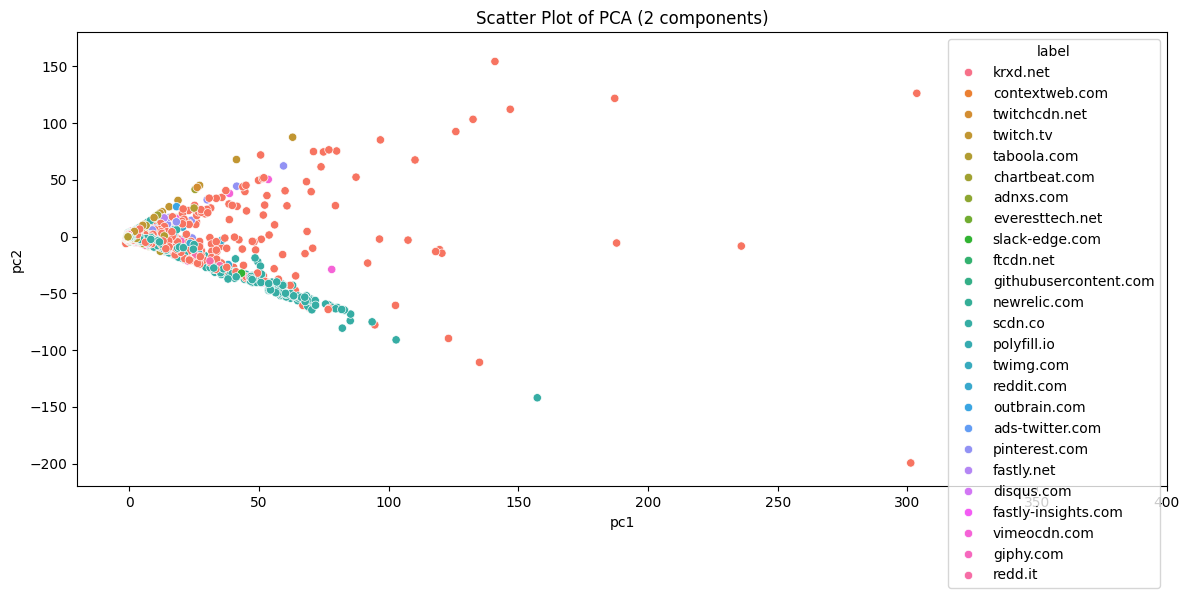

In [16]:
# pca scatter plot with 2 PCs
print(f'2 PCs explain {round(perc_cumul_exp_var[1], 2)}% of total variace')

# PCA transformation
pca_2pc = PCA(n_components=2, random_state=15)
# fit the data to new space
pca_2pc.fit(df_standardized.copy().drop(columns=['c_ip', 'label']))
# transform the original data into PCA components
pca_result_2pc = pca_2pc.transform(df_standardized.copy().drop(columns=['c_ip', 'label']))
# create the new dataset
df_pca_2pc= pd.DataFrame(pca_result_2pc,  columns=['pc1', 'pc2'])
df_pca_2pc

print('-'*100)

fig, axes = plt.subplots(1, 1, figsize=(12, 6))

sns.scatterplot(
    data=df_pca_2pc,
    x='pc1',
    y='pc2',
    ax=axes,
    hue=df['label']
)
axes.set_title('Scatter Plot of PCA (2 components)')
axes.set_ylim(-220,180)
axes.set_xlim(-20,400)


plt.tight_layout()
plt.show()

The scatterplot is **rappresenting PCA (2 principal components) dataset points in space**. It seems that datapoints with the same domain name value belong to a single cluster, except for a few outliers. \\
Moreover, there is a slight tendence to aggregation: the single cluster seems to be partitioned into different subsets of datapoints. \\
By the way, the PCA dataset with 2 features can capture the 19.76% of the total variance of data (original dataset). This means that the dataset is a **visual but poor rappresentation** in a 2 dimentional space of the original one.

##### **t-SNE implementation**

In [17]:
tsn_model = TSNE(n_components=2,  perplexity=50, early_exaggeration=12.0, learning_rate="auto", max_iter=None)
tsn_features = tsn_model.fit_transform(df_standardized.sample(frac=0.1, random_state=42).drop(columns=['c_ip', 'label']))
df_tsn = pd.DataFrame(tsn_features)
df_tsn

,0,1
0,-16.963610,63.673138
1,-8.438138,-70.243149
2,8.005830,-22.358164
3,-57.018665,3.090439
4,-40.884377,64.210655
...,...,...
14781,9.884821,70.939980
14782,9.990802,-84.639557
14783,-51.305141,33.457432
14784,31.650564,22.112864


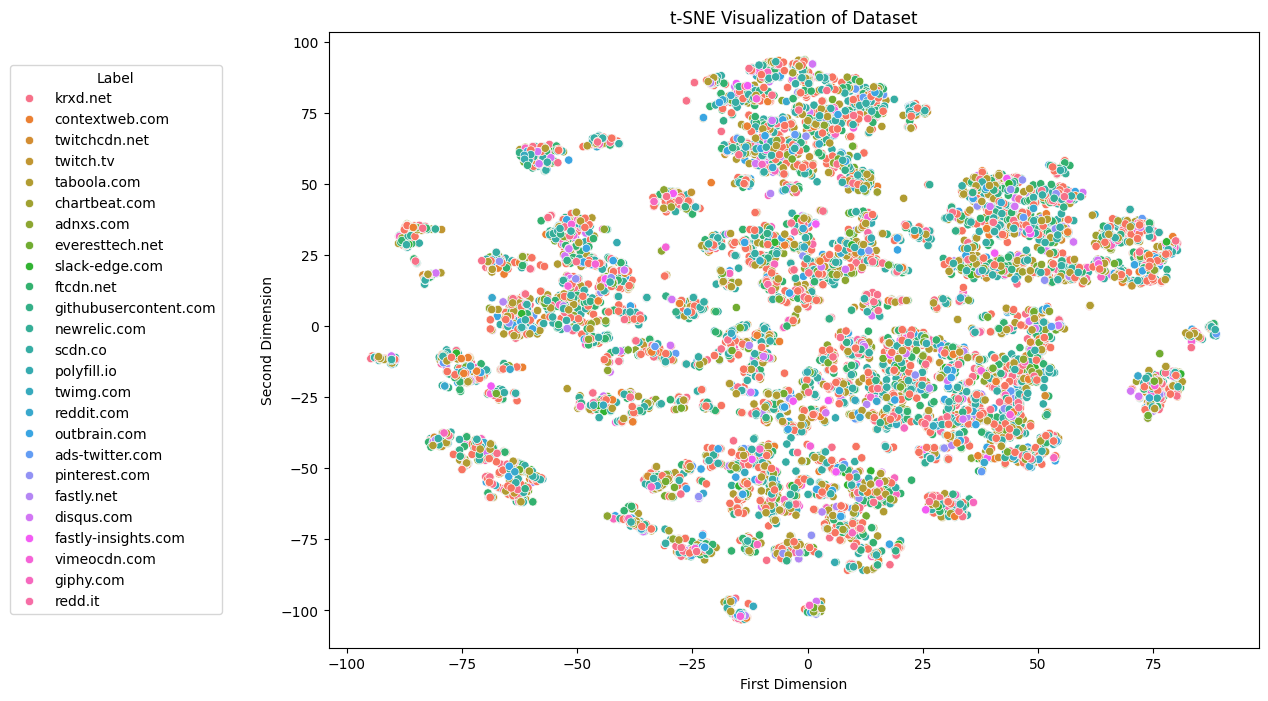

In [18]:
plt.figure(figsize=(12, 8))

scatter_plot = sns.scatterplot(data=df_tsn, x=0, y=1, hue=df['label'])
plt.legend(loc='center left', bbox_to_anchor=(-0.35, 0.5), title='Label')
plt.title('t-SNE Visualization of Dataset')
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')

plt.show()


t-SNE is a **visualization technique** that can help visualizing the distribution of points in a 2 dimentional space. Even though we cannot trust t-SNE clusters (the technique generates them), there is no sharp separation between datapoints with different domain name labels anticipating that classification task will be tricky.

# Section 2: supervised learning

After preprocessing and data visualization we are requested to perform supervised learning tasks. To do so, we can't use the original dataset due to its massive shape (both the number of rows and columns). \\
For this reason, we will use the **dataset obtained using the PCA** which is expressing the 99,00% of the original dataset variance. By doing that, we are reducing the number of features: it's like using the same dataset with almost the half of the columns. \\
As regards dataponts, we can perform a **sampling**: we can chose randomly a subset of the rows that is representative of the original dataset.

In [19]:
def plot_class_imbalance_cake(y, title='Class Distribution (Cake Plot)'):
    unique_labels, label_counts = np.unique(y, return_counts=True)
    percentages = (label_counts / np.sum(label_counts)) * 100

    plt.figure(figsize=(8, 8))
    # Create pie chart with labels and percentages
    wedges, _ = plt.pie(
        percentages,
        labels=None,
        autopct=None,
        startangle=90,
        textprops={'fontsize': 10}  # Adjust font size if needed
    )

    # Add a legend with color associations and percentage representation
    legend_labels = [
        f"{str(label).replace('_', '')} ({percentage:.1f}%)"
        for label, percentage in zip(unique_labels, percentages)
    ]

    plt.legend(
        wedges,
        legend_labels,
        title="Labels",
        loc="center left",
        bbox_to_anchor=(1, 0.5)
    )

    plt.title(title)
    plt.axis('equal')
    plt.show()

Shape of supervised learning dataset: (147863, 43) 



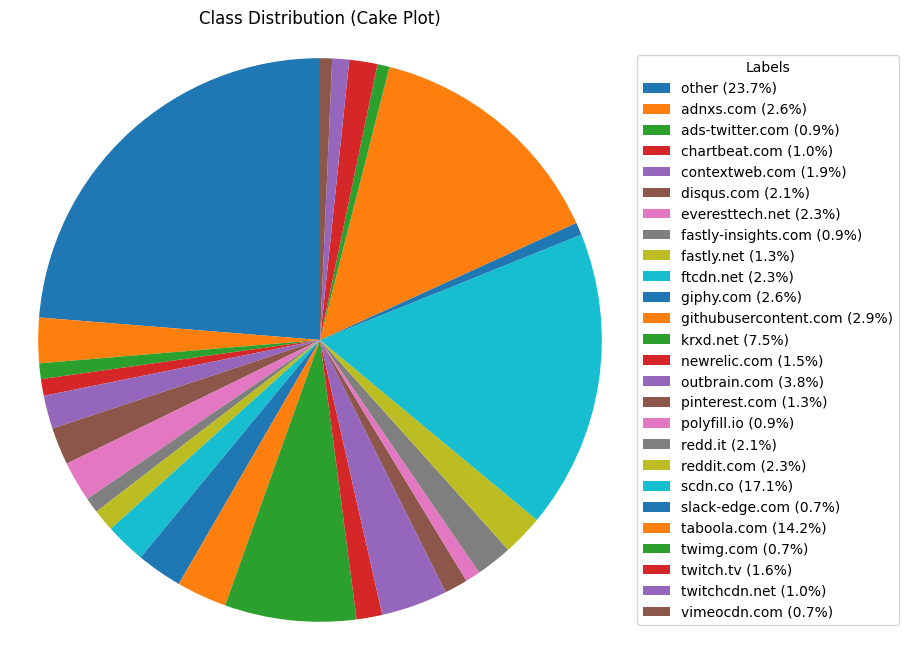

In [20]:
df_supervised_learning = df_pca.copy()
print(f"Shape of supervised learning dataset: {df_supervised_learning.shape} \n")

X = df_supervised_learning.drop(columns=['label'])
y = df_supervised_learning['label']
plot_class_imbalance_cake(y)

X['c_ip'] = pd.Categorical(X['c_ip']).codes
y = pd.Categorical(y).codes

In [21]:
# data segmentation
# notice that the validation set is called test, but is not the same!
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify = y, # stratify the dataset based on class labels
    train_size = 0.80, # percentage of training set
    random_state = 15
)

# standardize data using StandardScaler
scaler_train = StandardScaler()
scaler_train.fit(X_train.to_numpy())
X_train_s, X_test_s = scaler_train.transform(X_train.to_numpy()), scaler_train.transform(X_test.to_numpy())
print(f"X_train_s shape: {X_train_s.shape}, y_train shape: {y_train.shape}")
print(f"X_test_s shape: {X_test_s.shape}, y_test shape: {y_test.shape}")

X_train_s shape: (118290, 42), y_train shape: (118290,)
X_test_s shape: (29573, 42), y_test shape: (29573,)


#### **K Neighbors Classifier:**

**No hyperparameter tuning:**

In [22]:
# k-NN training and predicition
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(X_train_s, y_train)
y_train_pred_knn = knn.predict(X_train_s)
y_test_pred_knn = knn.predict(X_test_s)

knn_train_accuracy = accuracy_score(y_train, y_train_pred_knn)
knn_train_f1 = f1_score(y_train, y_train_pred_knn, average="weighted")
knn_test_accuracy = accuracy_score(y_test, y_test_pred_knn)
knn_test_f1 = f1_score(y_test, y_test_pred_knn, average="weighted")
y_test.shape
y_test_pred_knn.shape

print("---- ACCURACY SCORE ----")
print(f"Training set accuracy: {knn_train_accuracy}")
print(f"Test set accuracy: {knn_test_accuracy}")
print("\n---- F1 SCORE ----")
print(f"Training set f1 score: {knn_train_f1}")
print(f"Test set f1 score: {knn_test_f1}")
print("\n---- HYPERPARAM CONFIG ----")
print(f"Hyperparameter default configuration: \n" + str(knn.get_params()))

---- ACCURACY SCORE ----
Training set accuracy: 0.7780032124439936
Test set accuracy: 0.6800798025225713

---- F1 SCORE ----
Training set f1 score: 0.7705177859667081
Test set f1 score: 0.6688942886985497

---- HYPERPARAM CONFIG ----
Hyperparameter default configuration: 
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


**Hyperparameter tuning:**

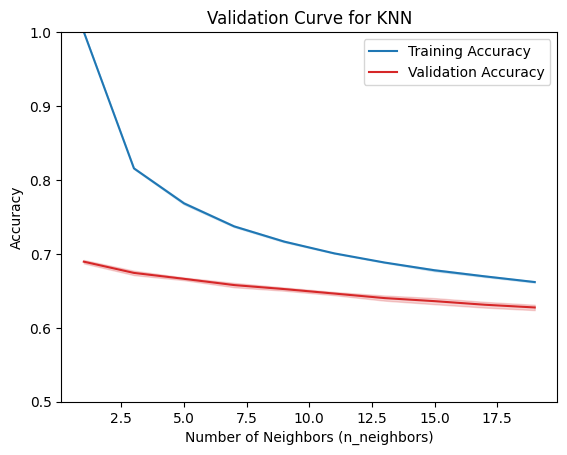

In [23]:
# Define the parameter range to explore
param_range = np.arange(1, 21, 2)

# Calculate training and validation scores using validation_curve
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(),  # Your estimator
    X_train_s, y_train,       # Training data
    param_name="n_neighbors", # Parameter to vary
    param_range=param_range,  # Range of parameter values
    cv=5,                     # Number of cross-validation folds
    scoring="accuracy",        # Scoring metric
    n_jobs=-1                 # Use all available CPU cores
)

# Calculate mean and standard deviation of scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure()
plt.plot(param_range, train_mean, color='tab:blue', label='Training Accuracy')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='tab:blue')
plt.plot(param_range, test_mean, color='tab:red', label='Validation Accuracy')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color='tab:red')

plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Accuracy')
plt.title('Validation Curve for KNN')
plt.legend(loc='best')
plt.ylim(0.5, 1)
plt.show()

In [42]:
#general grid
param_grid = {
                'n_neighbors': [3,5,7],  # Number of neighbors
                'weights': ['uniform'],        # Weighting scheme
                'p': [1, 2],                               # Distance metric (1: Manhattan, 2: Euclidean)
                'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric
                'n_jobs' : [-1]
            }

# Create a KNN classifier
knn = KNeighborsClassifier()

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3, n_jobs=-1,scoring='balanced_accuracy', verbose=3)
grid_search.fit(X_train_s, y_train)

# Print the best hyperparameters and the corresponding score
print(f"Best hyperparameters: {grid_search.best_params_}")

# Evaluate the best model on the test set
best_knn = grid_search.best_estimator_
y_pred_train = best_knn.predict(X_train_s)
y_pred_test = best_knn.predict(X_test_s)

accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train, average="weighted")
test_f1 = f1_score(y_test, y_pred_test, average="weighted")


print("---- ACCURACY SCORE ----")
print(f"Training set accuracy: {accuracy_train}")
print(f"Test set accuracy: {accuracy_test}")
print("\n---- F1 SCORE ----")
print(f"Training set f1 score: {train_f1}")
print(f"Test set f1 score: {test_f1}")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best hyperparameters: {'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
---- ACCURACY SCORE ----
Training set accuracy: 0.8312114295375771
Test set accuracy: 0.7030061204477057

---- F1 SCORE ----
Training set f1 score: 0.826755641833954
Test set f1 score: 0.6942310316491132


#### **Random Forest Classifier:**

**No hyperparameter tuning:**

In [25]:
# Random Forest training and predicition

rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

rf.fit(X_train_s, y_train)
y_train_pred_rf = rf.predict(X_train_s)
y_test_pred_rf = rf.predict(X_test_s)

rf_train_accuracy = accuracy_score(y_train, y_train_pred_rf)
rf_test_accuracy = accuracy_score(y_test, y_test_pred_rf)
rf_train_f1 = f1_score(y_train, y_train_pred_rf, average="weighted")
rf_test_f1 = f1_score(y_test, y_test_pred_rf, average="weighted")


print("---- ACCURACY SCORE ----")
print(f"Training set accuracy: {rf_train_accuracy}")
print(f"Test set accuracy: {rf_test_accuracy}")
print("\n---- F1 SCORE ----")
print(f"Training set f1 score: {rf_train_f1}")
print(f"Test set f1 score: {rf_test_f1}")
print("\n---- HYPERPARAM CONFIG ----")
print(f"Hyperparameter default configuration: \n" + str(rf.get_params()))

---- ACCURACY SCORE ----
Training set accuracy: 1.0
Test set accuracy: 0.7521725898623745

---- F1 SCORE ----
Training set f1 score: 1.0
Test set f1 score: 0.7391030906448335

---- HYPERPARAM CONFIG ----
Hyperparameter default configuration: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


**Hyperparameter tuning:**

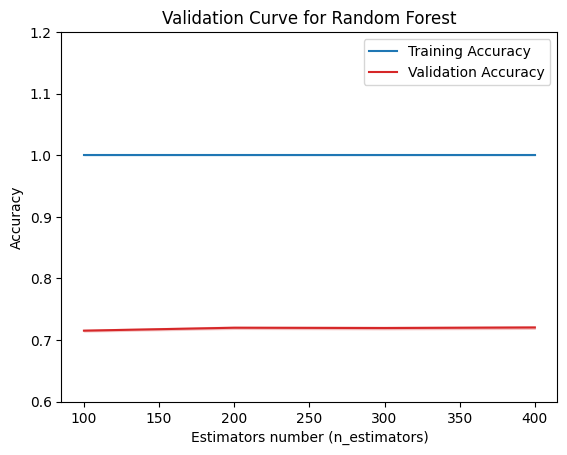

In [26]:
from sklearn.model_selection import validation_curve

# Define the parameter range to explore
param_range = np.arange(100,500,100)

# Calculate training and validation scores using validation_curve
train_scores, test_scores = validation_curve(
    RandomForestClassifier(),  # Your estimator
    X_train_s, y_train,       # Training data
    param_name="n_estimators", # Parameter to vary
    param_range=param_range,  # Range of parameter values
    cv=2,                     # Number of cross-validation folds
    scoring="accuracy"        # Scoring metric
    #n_jobs=-1                 # Use all available CPU cores
)

# Calculate mean and standard deviation of scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure()
plt.plot(param_range, train_mean, color='tab:blue', label='Training Accuracy')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='tab:blue')
plt.plot(param_range, test_mean, color='tab:red', label='Validation Accuracy')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color='tab:red')

plt.xlabel('Estimators number (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Validation Curve for Random Forest')
plt.legend(loc='best')
plt.ylim(0.6, 1.2)
plt.show()

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


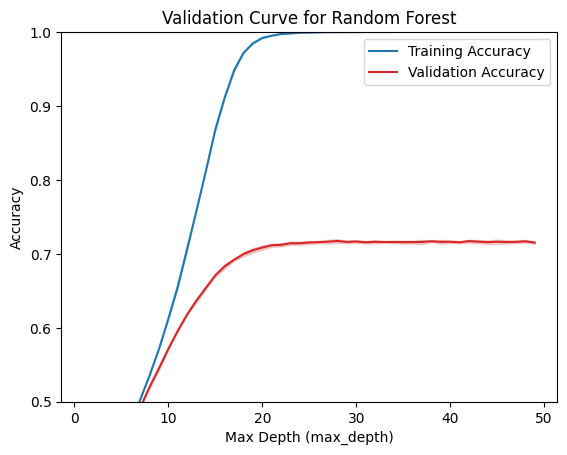

In [29]:
from sklearn.model_selection import validation_curve

# Define the parameter range to explore
param_range = np.arange(1,50)

# Calculate training and validation scores using validation_curve
train_scores, test_scores = validation_curve(
    RandomForestClassifier(),  # Your estimator
    X_train_s, y_train,       # Training data
    param_name="max_depth", # Parameter to vary
    param_range=param_range,  # Range of parameter values
    cv=2,                     # Number of cross-validation folds
    scoring="accuracy",        # Scoring metric
    n_jobs=-1                 # Use all available CPU cores
)

# Calculate mean and standard deviation of scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure()
plt.plot(param_range, train_mean, color='tab:blue', label='Training Accuracy')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='tab:blue')
plt.plot(param_range, test_mean, color='tab:red', label='Validation Accuracy')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color='tab:red')

plt.xlabel('Max Depth (max_depth)')
plt.ylabel('Accuracy')
plt.title('Validation Curve for Random Forest')
plt.legend(loc='best')
plt.ylim(0.5, 1)
plt.show()

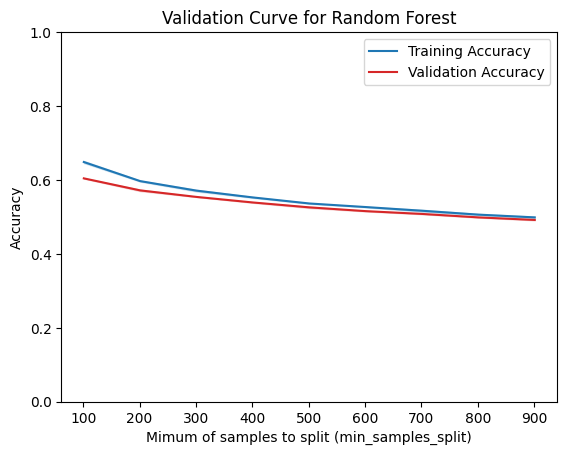

In [30]:
from sklearn.model_selection import validation_curve

# Define the parameter range to explore
param_range = np.arange(1,1001,100)

# Calculate training and validation scores using validation_curve
train_scores, test_scores = validation_curve(
    RandomForestClassifier(),  # Your estimator
    X_train_s, y_train,       # Training data
    param_name="min_samples_split", # Parameter to vary
    param_range=param_range,  # Range of parameter values
    cv=2,                     # Number of cross-validation folds
    scoring="accuracy",        # Scoring metric
    n_jobs=-1                 # Use all available CPU cores
)

# Calculate mean and standard deviation of scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure()
plt.plot(param_range, train_mean, color='tab:blue', label='Training Accuracy')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='tab:blue')
plt.plot(param_range, test_mean, color='tab:red', label='Validation Accuracy')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color='tab:red')

plt.xlabel('Mimum of samples to split (min_samples_split)')
plt.ylabel('Accuracy')
plt.title('Validation Curve for Random Forest')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.show()

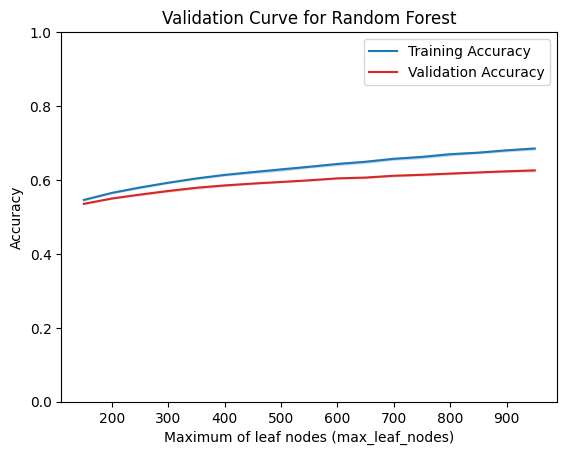

In [31]:
from sklearn.model_selection import validation_curve

# Define the parameter range to explore
param_range = np.arange(150,1000,50)

# Calculate training and validation scores using validation_curve
train_scores, test_scores = validation_curve(
    RandomForestClassifier(),  # Your estimator
    X_train_s, y_train,       # Training data
    param_name="max_leaf_nodes", # Parameter to vary
    param_range=param_range,  # Range of parameter values
    cv=2,                     # Number of cross-validation folds
    scoring="accuracy",        # Scoring metric
    n_jobs=-1                 # Use all available CPU cores
)

# Calculate mean and standard deviation of scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure()
plt.plot(param_range, train_mean, color='tab:blue', label='Training Accuracy')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='tab:blue')
plt.plot(param_range, test_mean, color='tab:red', label='Validation Accuracy')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color='tab:red')

plt.xlabel('Maximum of leaf nodes (max_leaf_nodes)')
plt.ylabel('Accuracy')
plt.title('Validation Curve for Random Forest')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.show()

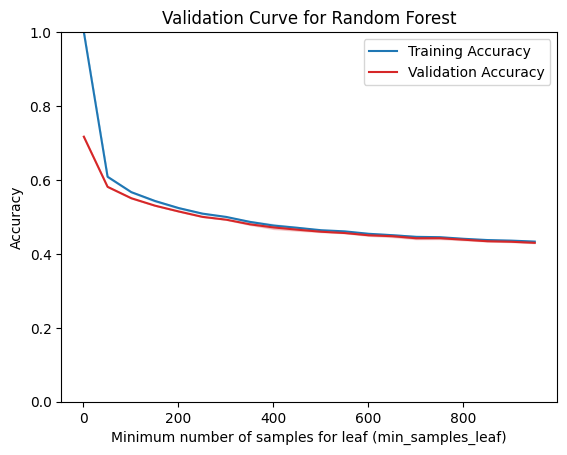

In [32]:
from sklearn.model_selection import validation_curve

# Define the parameter range to explore
param_range = np.arange(1,1000,50)

# Calculate training and validation scores using validation_curve
train_scores, test_scores = validation_curve(
    RandomForestClassifier(),  # Your estimator
    X_train_s, y_train,       # Training data
    param_name="min_samples_leaf", # Parameter to vary
    param_range=param_range,  # Range of parameter values
    cv=2,                     # Number of cross-validation folds
    scoring="accuracy",        # Scoring metric
    n_jobs=-1                 # Use all available CPU cores
)

# Calculate mean and standard deviation of scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure()
plt.plot(param_range, train_mean, color='tab:blue', label='Training Accuracy')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='tab:blue')
plt.plot(param_range, test_mean, color='tab:red', label='Validation Accuracy')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color='tab:red')

plt.xlabel('Minimum number of samples for leaf (min_samples_leaf)')
plt.ylabel('Accuracy')
plt.title('Validation Curve for Random Forest')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.show()

In [33]:
param_grid = {
                'n_estimators': [100],
                'max_depth': [20, 50, 100],
                'min_samples_split': [15, 20, 30],
                'max_leaf_nodes' : [100, 500],
                'min_samples_leaf': [1,2,8],
                'class_weight' : ['balanced']
            }

# Create a RF classifier
rf = RandomForestClassifier(random_state=42)

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=3)
grid_search.fit(X_train_s, y_train)

# Print the best hyperparameters and the corresponding score
print(f"Best hyperparameters: {grid_search.best_params_}")

# Evaluate the best model on the test set
best_rf = grid_search.best_estimator_
y_pred_test = best_rf.predict(X_test_s)
y_pred_train = best_rf.predict(X_train_s)

accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train, average="weighted")
test_f1 = f1_score(y_test, y_pred_test, average="weighted")

print(f"Best hyperparameters: {grid_search.best_params_}")

print("---- ACCURACY SCORE ----")
print(f"Training set accuracy: {accuracy_train}")
print(f"Test set accuracy: {accuracy_test}")
print("\n---- F1 SCORE ----")
print(f"Training set f1 score: {train_f1}")
print(f"Test set f1 score: {test_f1}")


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best hyperparameters: {'class_weight': 'balanced', 'max_depth': 20, 'max_leaf_nodes': 500, 'min_samples_leaf': 8, 'min_samples_split': 30, 'n_estimators': 100}
Best hyperparameters: {'class_weight': 'balanced', 'max_depth': 20, 'max_leaf_nodes': 500, 'min_samples_leaf': 8, 'min_samples_split': 30, 'n_estimators': 100}
---- ACCURACY SCORE ----
Training set accuracy: 0.47644771324710455
Test set accuracy: 0.4488553748351537

---- F1 SCORE ----
Training set f1 score: 0.46277870832754076
Test set f1 score: 0.4439235474967166


#### **Decision Tree:**

**No hyperparameter tuning:**

In [34]:
# Train an DTC model
dtc_model = DecisionTreeClassifier(random_state=42)
dtc_model.fit(X_train_s, y_train)
y_train_pred_dtc = dtc_model.predict(X_train_s)
y_test_pred_dtc = dtc_model.predict(X_test_s)

# Calculate metrics
dtc_train_accuracy = accuracy_score(y_train, y_train_pred_dtc)
dtc_train_f1 = f1_score(y_train, y_train_pred_dtc, average="weighted")
dtc_test_accuracy = accuracy_score(y_test, y_test_pred_dtc)
dtc_test_f1 = f1_score(y_test, y_test_pred_dtc, average="weighted")

# Print results
print("---- ACCURACY SCORE ----")
print(f"Training set accuracy: {dtc_train_accuracy}")
print(f"Test set accuracy: {dtc_test_accuracy}")
print("\n---- F1 SCORE ----")
print(f"Training set f1 score: {dtc_train_f1}")
print(f"Test set f1 score: {dtc_test_f1}")
print("\n---- HYPERPARAM CONFIG ----")
print(f"Hyperparameter default configuration: \n" + str(dtc_model.get_params()))


---- ACCURACY SCORE ----
Training set accuracy: 1.0
Test set accuracy: 0.6314543671592331

---- F1 SCORE ----
Training set f1 score: 1.0
Test set f1 score: 0.6314963632076341

---- HYPERPARAM CONFIG ----
Hyperparameter default configuration: 
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


**Hyperparameter tuning:**

In [35]:
# Define the parameter grid for DTC
param_grid_dtc = {
    'criterion': ['gini','entropy'],
    'max_depth': [2,3,4,5,6,7,8,9],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [1,2,3]
}

# Create an SVC classifier
dtc = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Perform GridSearchCV to find the best hyperparameters
grid_search_dtc = GridSearchCV(estimator=dtc, param_grid=param_grid_dtc, n_jobs=-1, cv=2, scoring='accuracy', verbose=3)
grid_search_dtc.fit(X_train_s, y_train)

# Print the best hyperparameters and the corresponding score
print(f"Best hyperparameters: {grid_search_dtc.best_params_}")

# Evaluate the best model on the test set
best_dtc = grid_search_dtc.best_estimator_
y_pred_test_dtc = best_dtc.predict(X_test_s)
y_pred_train_dtc = best_dtc.predict(X_train_s)

accuracy_test_dtc = accuracy_score(y_test, y_pred_test_dtc)
accuracy_train_dtc = accuracy_score(y_train, y_pred_train_dtc)
train_f1_dtc = f1_score(y_train, y_pred_train_dtc, average="weighted")
test_f1_dtc = f1_score(y_test, y_pred_test_dtc, average="weighted")

print("---- ACCURACY SCORE ----")
print(f"Training set accuracy: {accuracy_train_dtc}")
print(f"Test set accuracy: {accuracy_test_dtc}")
print("\n---- F1 SCORE ----")
print(f"Training set f1 score: {train_f1_dtc}")
print(f"Test set f1 score: {test_f1_dtc}")


Fitting 2 folds for each of 144 candidates, totalling 288 fits
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2}
---- ACCURACY SCORE ----
Training set accuracy: 0.33674866852650265
Test set accuracy: 0.3226929969904981

---- F1 SCORE ----
Training set f1 score: 0.3489215491581641
Test set f1 score: 0.338596740892778


#### **Misclassification Analysis:**

In [36]:
#Setting up the best model
#Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
knn = KNeighborsClassifier(n_neighbors=3, weights='uniform', metric='manhattan', p=1, n_jobs=-1)
knn.fit(X_train_s, y_train)

#predict the whole set
y_pred = knn.predict(X)

#performances
accuracy = accuracy_score(y, y_pred)
print(accuracy)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


0.7065188721992656


In [37]:
# Identify misclassified samples
misclassified_indices = np.where(y != y_pred)[0]

corrclassified_indices = np.where(y == y_pred)[0]

misclassified_samples = df_standardized.drop(columns=['c_ip','label']).iloc[misclassified_indices]
misclassified_true_labels = y[misclassified_indices]
misclassified_pred_labels = y_pred[misclassified_indices]


corrclassified_samples = df_standardized.drop(columns=['c_ip','label']).iloc[corrclassified_indices]
corrclassified_true_labels = y[corrclassified_indices]
corrclassified_pred_labels = y_pred[corrclassified_indices]

mis_means=misclassified_samples.mean(axis=0)

cor_means=corrclassified_samples.mean(axis=0)

means_diff=mis_means-cor_means
print(means_diff.abs().sort_values(ascending=False).head(20))

_s_msgsize1         0.264275
_s_win_min          0.236603
_c_tm_opt           0.236582
_s_tm_opt           0.236582
_c_ttl_min          0.229391
_s_pkts_data_avg    0.228374
_c_ttl_max          0.227953
_s_cwin_max         0.218567
_s_pktsize1         0.205642
_s_pkts_data_std    0.202779
_c_rtt_std          0.188613
_c_msgsize1         0.183879
_c_pktsize1         0.183847
_c_cwin_ini         0.183719
_c_pkts_data_avg    0.178424
_s_cwin_ini         0.176132
_s_rst_cnt          0.166503
_c_rst_cnt          0.144399
_c_rtt_max          0.126456
_s_mss_min          0.125319
dtype: float64


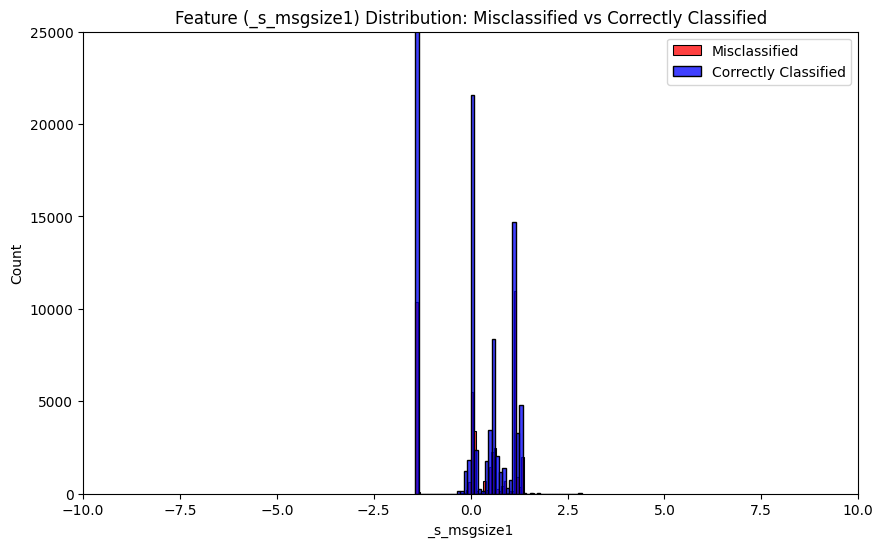

In [38]:
# Create misclas_df with generic column names first
misclas_df = pd.DataFrame(misclassified_samples)
corrclas_df = pd.DataFrame(corrclassified_samples)


# Create a DataFrame for analysis
misclas_df['True_Label'] = misclassified_true_labels
misclas_df['Predicted_Label'] = misclassified_pred_labels

corrclas_df['True_Label'] = corrclassified_true_labels
corrclas_df['Predicted_Label'] = corrclassified_pred_labels

# Compare feature distributions

feat_to_plot='_s_msgsize1' #INSERT HERE FEATURE NAME TO SPLOT ITS DISTRIBUTION

plt.figure(figsize=(10, 6))
sns.histplot(data=misclas_df, x=feat_to_plot, label='Misclassified', color='red')
sns.histplot(data=corrclas_df, x=feat_to_plot, label='Correctly Classified', color='blue')
plt.legend()
plt.title(f'Feature ({feat_to_plot}) Distribution: Misclassified vs Correctly Classified')
plt.ylim(0,25000)
plt.xlim(-10,10)
plt.show()